In [1]:
import h5py
from PIL import Image
from code.dataset import DiganesDataset
from torch.utils.data import random_split
import torch
import pandas as pd
import os
import numpy as np

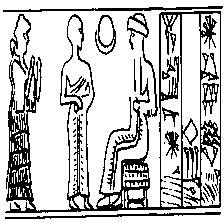

In [4]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/bw_pics'
dataset = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50)
dataset[16][0]

In [5]:
N = len(dataset)
train_size = int(N * 0.8)
val_size = int(N * 0.1)
test_size = N - (train_size + val_size)

torch.manual_seed(32)
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [7]:
val_set[16]

(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=224x224 at 0x7FBADBD25E10>,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]))

In [4]:
permutations = pd.DataFrame([x for x in os.listdir(pic_dir)if
                                  (x.startswith('per') and x.endswith(".jpg"))],columns=['Filename'])

size_per = 0
for idx in range(len(train_set)):
    _, img_name = os.path.split(train_set[idx][0].filename)
    per_match = permutations[permutations['Filename'].str.contains(img_name)]
    size_per += len(per_match)

In [5]:
out_train = h5py.File('diganes_train_dataset.h5', "w")
out_train.create_dataset("X",(train_size + size_per, 224, 224, 3),dtype='u1')
out_train.create_dataset("Y",(train_size + size_per, 1, len(dataset.classes)),dtype='u1') 

out_val = h5py.File('diganes_val_dataset.h5', "w")
out_val.create_dataset("X",(val_size, 224, 224, 3),dtype='u1')
out_val.create_dataset("Y",(val_size, 1, len(dataset.classes)),dtype='u1')   

out_test = h5py.File('diganes_test_dataset.h5', "w")
out_test.create_dataset("X",(test_size, 224, 224, 3),dtype='u1')
out_test.create_dataset("Y",(test_size,1 ,len(dataset.classes)),dtype='u1')   

<HDF5 dataset "Y": shape (148, 1, 29), type "|u1">

In [6]:
j = 0
for i in range(len(train_set)):
    image, labels = train_set[i]
    out_train["X"][j] = np.asarray(image.convert('RGB'))
    out_train["Y"][j] = np.asarray(labels)
    j += 1
    
    _, img_name = os.path.split(image.filename)
    per_match = permutations[permutations['Filename'].str.contains(img_name)]
    
    for t in range(len(per_match)):
        chosen_per = per_match.iloc[t, 0]
        per_image = Image.open(os.path.join(pic_dir, chosen_per))
        out_train["X"][j] = np.asarray(per_image.convert('RGB'))
        out_train["Y"][j] = np.asarray(labels)
        j+=1

In [7]:
 for i in range(len(val_set)):
    image, labels = val_set[i]
    out_val["X"][i] = np.asarray(image.convert('RGB'))
    out_val["Y"][i] = np.asarray(labels)

In [8]:
for i in range(len(test_set)):
    image, labels = test_set[i]
    out_test["X"][i] = np.asarray(image.convert('RGB'))
    out_test["Y"][i] = np.asarray(labels)

In [9]:
out_train.close()
out_val.close()
out_test.close()